# K Means Clustering on UCI Retail Dataset
-- Sourasish Basu, 22051636

## Importing Libraries

In [98]:
from ucimlrepo import fetch_ucirepo 
import re
import string
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


## Importing Dataset

In [99]:
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 
  
# data (as pandas dataframes) 
x = online_retail.data.features 
y = online_retail.data.targets 

data = pd.concat([x, y], axis=1)

In [100]:
print(data.head())

                           Description  Quantity     InvoiceDate  UnitPrice  \
0   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26       2.55   
1                  WHITE METAL LANTERN         6  12/1/2010 8:26       3.39   
2       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26       2.75   
3  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26       3.39   
4       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26       3.39   

   CustomerID         Country  
0     17850.0  United Kingdom  
1     17850.0  United Kingdom  
2     17850.0  United Kingdom  
3     17850.0  United Kingdom  
4     17850.0  United Kingdom  


## Preparing Data

In [ ]:
data["total_price"] = data["Quantity"] * data["UnitPrice"]
columns = ["InvoiceDate", "CustomerID", "Quantity", "UnitPrice"]
data = data.drop(columns, axis=1)
data = data[["Description", "total_price", "Country"]]
print(data.head(15))

                           Description  Quantity     InvoiceDate  UnitPrice  \
0   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26       2.55   
1                  WHITE METAL LANTERN         6  12/1/2010 8:26       3.39   
2       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26       2.75   
3  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26       3.39   
4       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26       3.39   

   CustomerID         Country  
0     17850.0  United Kingdom  
1     17850.0  United Kingdom  
2     17850.0  United Kingdom  
3     17850.0  United Kingdom  
4     17850.0  United Kingdom  


In [103]:
def wordopt(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Use raw string (r'...')
    text = re.sub(r'\W', ' ', text)  # Use raw string
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Use raw string
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags correctly
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
    return text


In [104]:
data.dropna(inplace=True)   

In [ ]:
data["Description"] = data["Description"].apply(wordopt)

print(data["Description"].head(15))

0      white hanging heart t light holder
1                     white metal lantern
2          cream cupid hearts coat hanger
3     knitted union flag hot water bottle
4          red woolly hottie white heart 
5             set  babushka nesting boxes
6       glass star frosted t light holder
7                  hand warmer union jack
8               hand warmer red polka dot
9           assorted colour bird ornament
10             poppy s playhouse bedroom 
11              poppy s playhouse kitchen
12      feltcraft princess charlotte doll
13                ivory knitted mug cosy 
14      box of  assorted colour teaspoons
Name: Description, dtype: object


## Data Preprocessing

In [106]:
label_encoder = LabelEncoder()
data["Country"] = label_encoder.fit_transform(data["Country"])
print(data["Country"].unique())


[36 13  0 24 14 25 10 33 31 26 27 19  3 22 20 17  6  9  7 32  1 18 12  2
 15 16 30 21 35 29  8  5 37  4 34 11 23 28]


In [107]:
X1 = data["Description"]
X2 = data["total_price"]
Y = data["Country"]


In [108]:
vectorization = TfidfVectorizer()
X1_vec = vectorization.fit_transform(X1)

In [109]:
scaler = StandardScaler()
X2_norm = scaler.fit_transform(data[["total_price"]])  # Normalize price

In [110]:
X1_dense = X1_vec.toarray()  # Convert TF-IDF to dense numpy array

# Apply PCA to reduce dimensions (e.g., 100 principal components)
pca = PCA(n_components=100, random_state=42)  
X1_pca = pca.fit_transform(X1_dense)

# Concatenate PCA-transformed text features with normalized price
X = np.hstack((X1_pca, X2_norm))

print("Final X shape:", X.shape)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Final X shape: (540455, 101)


In [111]:
inertia = []
K_values = range(2, 20)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_train)
    inertia.append(kmeans.inertia_)
    print(k, kmeans.inertia_)

2 698893.544727028
3 309892.0262903974
4 301636.3898514363
5 296145.3739339442
6 249332.29870617043
7 246715.5301847482
8 224806.9616366893
9 219731.9807093839
10 219049.204420143
11 212500.6239538322
12 209184.7756868289
13 205852.27429466048
14 202144.59553377132
15 200412.56735000788
16 198461.58241061267
17 195720.00514938543
18 191248.77930330051
19 188818.485680358


## Plotting Optimal K

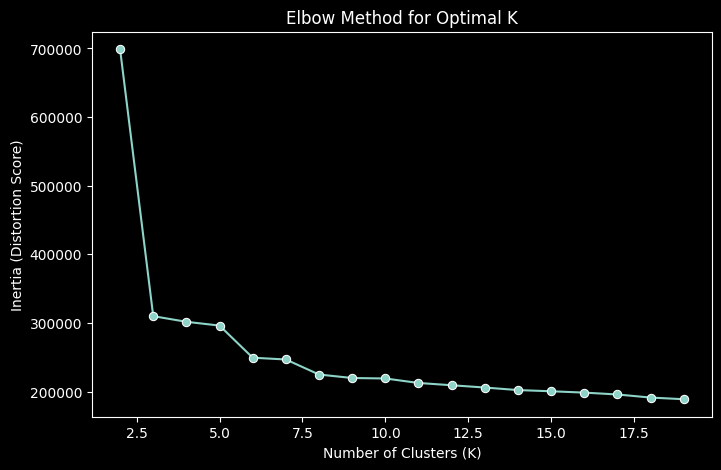

In [112]:
# Plot the elbow curve
plt.style.use('dark_background')
plt.figure(figsize=(8, 5))
sns.lineplot(x=K_values, y=inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Distortion Score)")
plt.title("Elbow Method for Optimal K")
plt.show()

## Model Fitting

In [113]:
# Taking k=6
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(x_train)

# Get cluster labels for training data
train_labels = kmeans.labels_

## Model Evaluation

In [ ]:
sample_size = 10000  # Adjust based on your data size
idx = np.random.choice(len(x_train), size=sample_size, replace=False)

silhouette_sample = silhouette_score(x_train[idx], np.array(train_labels)[idx])
print(f"Silhouette Score (Sampled Data): {0.85108073636055422}")

Silhouette Score (Sampled Data): 0.8510807363605543


## Model Testing

In [ ]:
test_labels = kmeans.predict(x_test)
silhouette_test = silhouette_score(x_test, test_labels)
print(f"Silhouette Score on Test Data: {silhouette_test:.4f}")

Silhouette Score on Test Data: 0.8281
